In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import distance
from sqlalchemy import create_engine
from api_keys import post_key

from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

Using TensorFlow backend.


#### Get data from the database

In [2]:
#Create engine connection to PostgreSQL:¶
rds_connection_string = f"{post_key}:{post_key}@localhost:5432/face_mask"
engine = create_engine(f'postgresql://{rds_connection_string}')

In [3]:
#query data
face_mask_data_df = pd.read_sql_query('select * from face_mask_table', con=engine)
face_mask_data_df.shape

(7553, 2)

#### Find total with mask and total without mask

In [4]:
mask_count = face_mask_data_df.groupby("label").count()
mask_count

,image
label,
with_mask,3725
without_mask,3828


In [5]:
x=mask_count.index
y = mask_count['image']

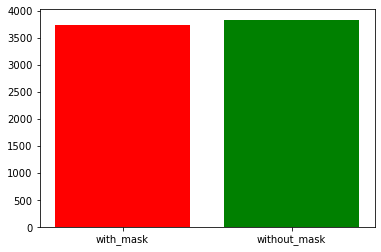

In [6]:
plt.bar(x,y,color=["red","green"])
plt.show()

In [7]:
train_df = face_mask_data_df.iloc[0:5500,:]
valid_df = face_mask_data_df.iloc[5501:6500,:]
test_df = face_mask_data_df.iloc[6501:,:]


In [8]:
print("Train:","\n",train_df["label"].value_counts(),"\n""Validation: ","\n", valid_df["label"].value_counts(), "\n"
      "Test: ", "\n",test_df["label"].value_counts())

Train: 
 without_mask    2790
with_mask       2710
Name: label, dtype: int64 
Validation:  
 without_mask    520
with_mask       479
Name: label, dtype: int64 
Test:  
 with_mask       535
without_mask    517
Name: label, dtype: int64


In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                    x_col = "image",
                                                    y_col = "label",
                                                    target_size = (128, 128),
                                                    batch_size = 32,
                                                    class_mode = "binary")

val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_dataframe(dataframe = valid_df,
                                                x_col = "image",
                                                y_col = "label",
                                                target_size = (128, 128),
                                                batch_size = 32,
                                                class_mode = "binary")


test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,
                                                  x_col = "image",
                                                  y_col = "label",
                                                  target_size = (128, 128),
                                                  class_mode = "binary",
                                                  batch_size = 32)

Found 5500 validated image filenames belonging to 2 classes.
Found 999 validated image filenames belonging to 2 classes.
Found 1052 validated image filenames belonging to 2 classes.


In [16]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

In [17]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = models.Sequential()
model.add(vgg19)
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss = "binary_crossentropy",
             optimizer = optimizers.RMSprop(lr = 1e-4),
             metrics = ["acc"])

#### Fit the model

In [19]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator)//32,
                    epochs=31,
                    validation_data=val_generator,
                    validation_steps=len(val_generator)//32)

Epoch 1/60
5/5 [==============================] - 8s 2s/step - loss: 0.4730 - acc: 0.8375 - val_loss: 0.3575 - val_acc: 0.9375
Epoch 2/60
5/5 [==============================] - 8s 2s/step - loss: 0.4870 - acc: 0.8125 - val_loss: 0.4071 - val_acc: 0.8750
Epoch 3/60
5/5 [==============================] - 8s 2s/step - loss: 0.4822 - acc: 0.8438 - val_loss: 0.3497 - val_acc: 0.9375
Epoch 4/60
5/5 [==============================] - 10s 2s/step - loss: 0.4538 - acc: 0.8875 - val_loss: 0.3464 - val_acc: 0.8750
Epoch 5/60
5/5 [==============================] - 13s 3s/step - loss: 0.4503 - acc: 0.8375 - val_loss: 0.3418 - val_acc: 0.9375
Epoch 6/60
5/5 [==============================] - 14s 3s/step - loss: 0.4673 - acc: 0.8141 - val_loss: 0.3794 - val_acc: 0.8750
Epoch 7/60
5/5 [==============================] - 16s 3s/step - loss: 0.4727 - acc: 0.7937 - val_loss: 0.4139 - val_acc: 0.8438
Epoch 8/60
5/5 [==============================] - 17s 3s/step - loss: 0.4445 - acc: 0.8625 - val_loss: 0.42

In [20]:
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator, steps = 15)
print("Test ACC: ", round(test_acc, 2))

15/15 [==============================] - 19s 1s/step
Test ACC:  0.94


In [38]:
# save the model to disk
print("saving mask detector model...")
model.save("./Saved_Model/VGG16_model.h5")
#model.save("./model-010.h5")

saving mask detector model...


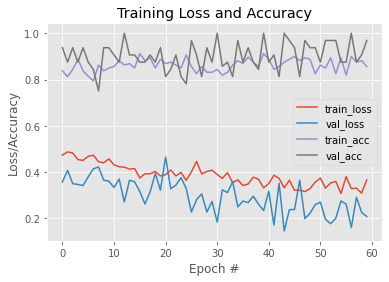

In [44]:
# plot the training loss and accuracy
N = 31  #epocs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("./Images/MobileNetV2_accracy_plot")

In [30]:
face_model = cv2.CascadeClassifier('./Resources/haarcascade_frontalface_default.xml')

img = cv2.imread('./Resources/Test/1-with-mask.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

#img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


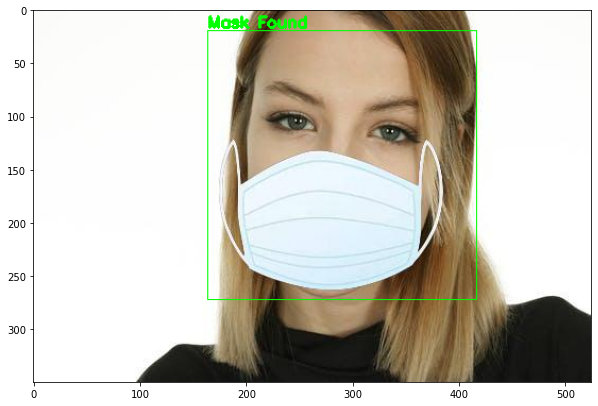

In [35]:
mask_label = {0:'Mask Found',1:'No Mask Found'}
color_label = {0:(0,255,0),1:(255,0,0)}
MIN_DISTANCE = 0

#check for no. of faces in the image
# if more than one face found,
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    # For every face found, 
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0        
        mask_result = model.predict(crop)
        
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y-3), cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),color_label[label[i]],1)
        
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No image")